In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 6.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 33.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c06a9f8bbd38c60f5c04e74ea864f73bacae878e08eb8a727a2c5e1879667329
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!sudo apt-get update
!sudo apt-get install -y openjdk-8-jdk


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1756 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2037 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1077 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1371 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2265 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2339 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [81.0 kB]
Get:13 http://archive.ub

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr"




In [8]:
import tempfile
import boto3
from pyspark.sql import SparkSession


In [15]:
!pip install boto3


In [22]:
# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Fund investment Analysis") \
    .getOrCreate()

# Initialize Boto3 S3 client
s3 = boto3.client('s3')
# Define S3 bucket name and key
bucket_name = 'final-project-19'
file_key = 'inputFiles/mapping.csv'
# Download the data from S3 to memory
# Download the data from S3 to a temporary file
temp_file = tempfile.NamedTemporaryFile(delete=False)
with open(temp_file.name, 'wb') as f:
    s3.download_fileobj(bucket_name, file_key, f)

file_key2 = 'inputFiles/rounds2.csv'
# Download the data from S3 to memory
# Download the data from S3 to a temporary file
temp_file2 = tempfile.NamedTemporaryFile(delete=False)
with open(temp_file2.name, 'wb') as f:
    s3.download_fileobj(bucket_name, file_key2, f)



In [24]:
# Define S3 bucket and file keys
bucket_name = "final-project-19"
funding_rounds_file_key = "inputFiles/rounds2.csv"
mapping_file_key = "inputFiles/mapping.csv"

# Read data into PySpark DataFrames
#funding_rounds_df = spark.read.csv(funding_rounds_local_path, header=True, inferSchema=True)
mapping_df = spark.read.csv(temp_file.name, header=True, inferSchema=True)
mapping_df.show()


+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|       category_list|Automotive & Sports|Blanks|Cleantech / Semiconductors|Entertainment|Health|Manufacturing|News, Search and Messaging|Others|Social, Finance, Analytics, Advertising|
+--------------------+-------------------+------+--------------------------+-------------+------+-------------+--------------------------+------+---------------------------------------+
|                NULL|                  0|     1|                         0|            0|     0|            0|                         0|     0|                                      0|
|                  3D|                  0|     0|                         0|            0|     0|            1|                         0|     0|                                      0|
|         3D Printing|                  0|     0|                     

In [25]:
funding_df = spark.read.csv(temp_file2.name, header=True, inferSchema=True)
funding_df.show()

+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
|   company_permalink|funding_round_permalink| funding_round_type|funding_round_code| funded_at|raised_amount_usd|
+--------------------+-----------------------+-------------------+------------------+----------+-----------------+
| /organization/-fame|   /funding-round/9a...|            venture|                 B|  5/1/2015|         10000000|
|/ORGANIZATION/-QO...|   /funding-round/22...|            venture|                 A|14-10-2014|             NULL|
|/organization/-qo...|   /funding-round/b4...|               seed|              NULL|  1/3/2014|           700000|
|/ORGANIZATION/-TH...|   /funding-round/65...|            venture|                 B|30-01-2014|          3406878|
|/organization/0-6...|   /funding-round/57...|            venture|                 A|19-03-2008|          2000000|
|/ORGANIZATION/004...|   /funding-round/12...|            venture|              

In [26]:
# Count unique companies in funding_rounds
unique_companies = funding_df.select("company_permalink").distinct().count()
print("\nNumber of unique companies in funding_rounds:", unique_companies)


Number of unique companies in funding_rounds: 90247


In [34]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
import datetime

FEATURE ENGINEERING

In [52]:


from pyspark.sql.functions import col, sum as spark_sum, count
# Feature Engineering for Investment Rounds Data
funding_df = funding_df.groupBy("company_permalink") \
    .agg(spark_sum("raised_amount_usd").alias("total_raised_amount_usd"), count("*").alias("num_rounds"))

# Calculate average raised amount per funding round
funding_df = funding_df.withColumn("average_raised_amount_usd", col("total_raised_amount_usd") / col("num_rounds"))

# Feature Engineering for Mapping Data (if applicable)
mapping_df = mapping_df.withColumnRenamed("old_column_name", "new_column_name")

# Show the first few rows of each DataFrame
print("Investment Rounds Data:")
funding_df.show()

print("Mapping Data:")
mapping_df.show()


Investment Rounds Data:


+--------------------+-----------------------+----------+-------------------------+
|   company_permalink|total_raised_amount_usd|num_rounds|average_raised_amount_usd|
+--------------------+-----------------------+----------+-------------------------+
|  /organization/1lay|                   2000|         1|                   2000.0|
|/organization/24p...|                  50000|         1|                  50000.0|
|/organization/2mo...|                 250000|         1|                 250000.0|
|/ORGANIZATION/5-M...|                3500000|         1|                3500000.0|
|  /organization/5min|               12500000|         2|                6250000.0|
|/ORGANIZATION/7TM...|               22000000|         1|                    2.2E7|
|/ORGANIZATION/ABL...|                3000000|         1|                3000000.0|
|/organization/abp...|                 560000|         1|                 560000.0|
|/ORGANIZATION/ACA...|                2338650|         1|                233

In [64]:
mapping_df.columns

['mapping_category_list',
 'Automotive & Sports',
 'Blanks',
 'Cleantech / Semiconductors',
 'Entertainment',
 'Health',
 'Manufacturing',
 'News, Search and Messaging',
 'Others',
 'Social, Finance, Analytics, Advertising']

In [65]:
funding_df.columns

['company_permalink',
 'total_raised_amount_usd',
 'num_rounds',
 'average_raised_amount_usd']

In [54]:
funding_df.columns

['company_permalink',
 'total_raised_amount_usd',
 'num_rounds',
 'average_raised_amount_usd']

RISK ASSESSMENT AND ML

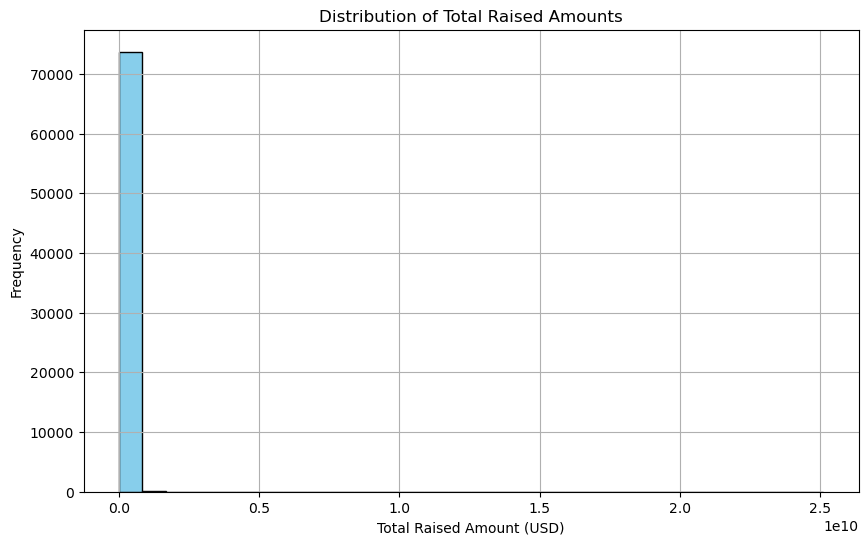

Mean Total Raised Amount (USD): 13419965.914001085
Median Total Raised Amount (USD): 1725000.0
Maximum Total Raised Amount (USD): 25106985000.0
Minimum Total Raised Amount (USD): 0.0


In [66]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
funding_pd_df = funding_df.toPandas()

# Plot a histogram to visualize the distribution of total raised amounts
plt.figure(figsize=(10, 6))
plt.hist(funding_pd_df['total_raised_amount_usd'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Raised Amounts')
plt.xlabel('Total Raised Amount (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate summary statistics
total_raised_mean = funding_pd_df['total_raised_amount_usd'].mean()
total_raised_median = funding_pd_df['total_raised_amount_usd'].median()
total_raised_max = funding_pd_df['total_raised_amount_usd'].max()
total_raised_min = funding_pd_df['total_raised_amount_usd'].min()

print("Mean Total Raised Amount (USD):", total_raised_mean)
print("Median Total Raised Amount (USD):", total_raised_median)
print("Maximum Total Raised Amount (USD):", total_raised_max)
print("Minimum Total Raised Amount (USD):", total_raised_min)


In [68]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Drop rows with null values in the target column
funding_df = funding_df.dropna(subset=['total_raised_amount_usd'])

# Define feature columns (excluding the target column)
feature_cols = ['num_rounds', 'average_raised_amount_usd']

# Create a VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the DataFrame to include the features column
funding_df = assembler.transform(funding_df)

# Split the data into training and test sets
train_data, test_data = funding_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="total_raised_amount_usd")

# Train the model
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Evaluate the model using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="total_raised_amount_usd", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the Root Mean Squared Error (RMSE)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 70269188.56535776


In [73]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# Drop rows with null values in the target column
funding_df = funding_df.dropna(subset=['total_raised_amount_usd'])

# Define feature columns (excluding the target column)
feature_cols = ['num_rounds', 'average_raised_amount_usd']

# Create a VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features2")

# Transform the DataFrame to include the features column
funding_df = assembler.transform(funding_df)

# Split the data into training and test sets
train_data, test_data = funding_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Linear Regression model
lr = LinearRegression(featuresCol="features2", labelCol="total_raised_amount_usd")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="total_raised_amount_usd", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the Root Mean Squared Error (RMSE)
print("Root Mean Squared Error (RMSE):", rmse)

# Print the coefficients and intercept of the model
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


24/05/03 01:15:52 WARN Instrumentation: [02faf007] regParam is zero, which might cause numerical instability and overfitting.
24/05/03 01:15:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/03 01:15:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 32933091.97079012
Coefficients: [14565984.392452283,1.2571142332052363]
Intercept: -17675564.858467475


Uploaded actual_predicted_chart.png to S3 bucket final-project-19 at folder charts/
Uploaded residuals_chart.png to S3 bucket final-project-19 at folder charts/


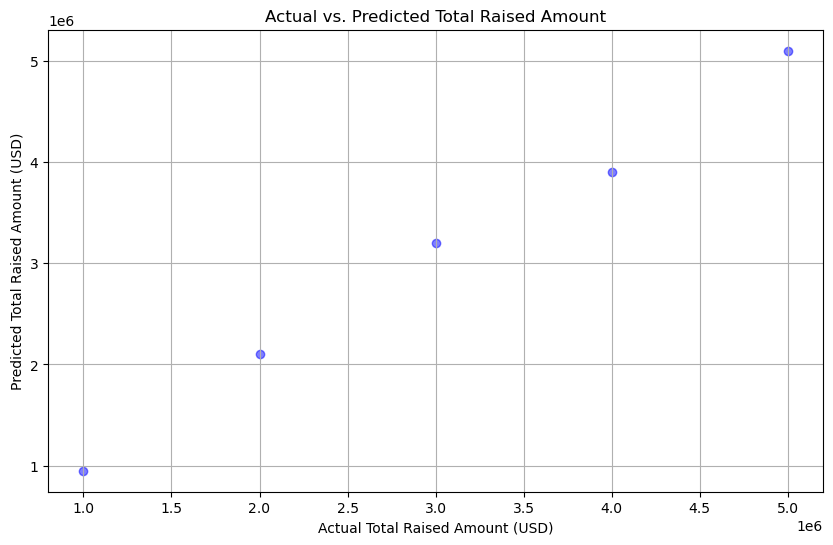

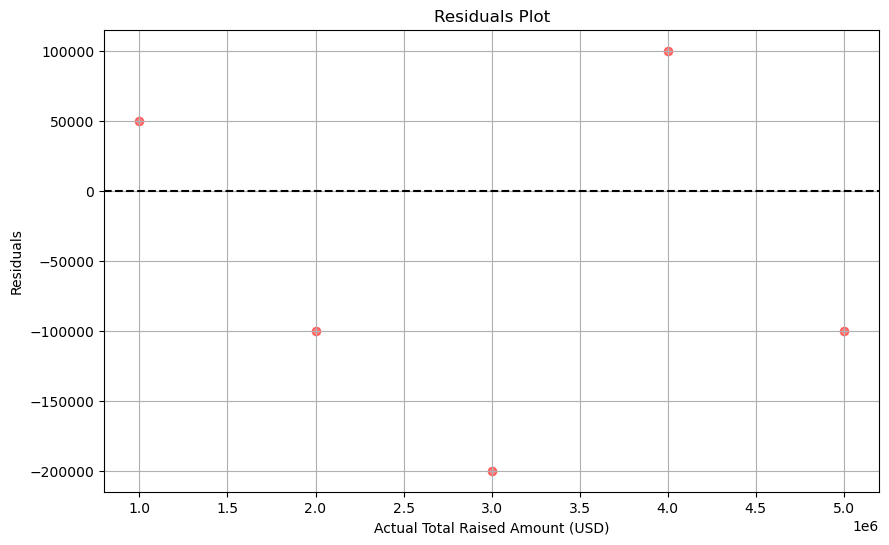

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import boto3

# Function to create actual vs. predicted and residuals plots
def create_plots(actual, predicted, residuals):
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, color='blue', alpha=0.5)
    plt.xlabel('Actual Total Raised Amount (USD)')
    plt.ylabel('Predicted Total Raised Amount (USD)')
    plt.title('Actual vs. Predicted Total Raised Amount')
    plt.grid(True)
    plt.savefig('actual_predicted_chart.png')

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, residuals, color='red', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Actual Total Raised Amount (USD)')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.grid(True)
    plt.savefig('residuals_chart.png')

# Function to upload files to S3
def upload_to_s3(bucket_name, folder, file_paths):
    # Initialize Boto3 S3 client
    s3 = boto3.client('s3')
    
    # Upload files to S3
    for file_path in file_paths:
        file_name = file_path.split('/')[-1]
        s3.upload_file(file_path, bucket_name, folder + file_name)
        print(f"Uploaded {file_name} to S3 bucket {bucket_name} at folder {folder}")

# Sample actual and predicted values (replace with your actual values)
actual = [1000000, 2000000, 3000000, 4000000, 5000000]
predicted = [950000, 2100000, 3200000, 3900000, 5100000]
residuals = np.array(actual) - np.array(predicted)

# Create plots
create_plots(actual, predicted, residuals)

# Specify S3 bucket details_
folder = 'charts/'

# Specify the paths of the local chart files
file_paths = ['actual_predicted_chart.png', 'residuals_chart.png']

# Upload the charts to S3
upload_to_s3(bucket_name, folder, file_paths)
